# Sequence to sequence translation

Input file: eng-fra.txt (English-French pair sentences)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Requirements

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing the data

In order to train our text generation model, we need to transform raw text into training data. \\
For each language, we have to convert every words into numerical data, in order our model to mathematically process them. To do that, we create a **vocabulary**, i.e. a dictionary in which each token is mapped to a different index.  One can add special tokens values for delimiting start or end of a sentence, or for unknown tokens (not encountered in training or discarded from the vocabulary). \\
The next cell shows the vocabulary creation.

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Data are in Unicode, next cell aims to convert it into ASCII caracters and uniform them.

In [ ]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

Next cell enables to form sentences pairs between the two languages. 

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


Then, in order to speed up training, we decide to filter sentences and only keep short ones, beginning with following prefixes:

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

We execute all these functions to obtain training data:

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['j en suis vraiment fier .', 'i m really proud of it .']


Finally, as suggested above, we convert words into numerical values. 

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

  
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# The Encoder

Recall the encoder-decoder architecture:

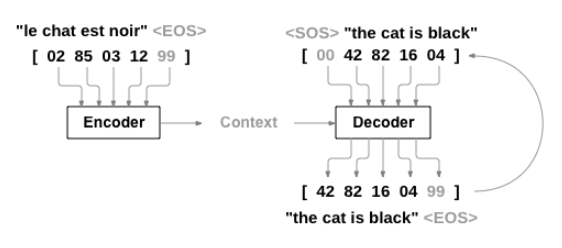

We first implement the encoder part. It is a network module, composed of : 

* an Embedding Layer : Currently, our tokens are encoded as one-dimensional integers. This is not ideal for learning, as we want representations to be as disentangled as possible, i.e. that our model can easily separate different explainable factors of our data. Hence, it is common to represent tokens as multi-dimensional vectors. This layer learns a nice representation of the inputs. Here, we consider that the embedding dimension is the same as the hidden dimension of the RNN.

* a recurrent layer, like a classical RNN, or a Gated RNN such as GRU and LSTM. **We'll use a GRU for this session.**

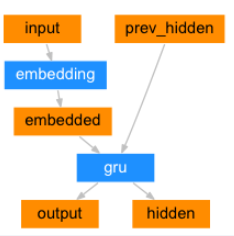


##### Hint

You may want to visit 
You may want to visit https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html and https://pytorch.org/docs/stable/generated/torch.nn.GRU.html to fill the gaps below

# Your turn now !

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()

        ### START CODE HERE ###

        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size,hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

        ### END CODE HERE ###

    def forward(self, input, hidden):

        ### START CODE HERE ###

        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden


    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size , device=device)

         ### END CODE HERE ###

# The Decoder

The other part of the global architecture is the Decoder. It is composed of: 

* an Embedding layer, to map previous output words to multi-dimensional vectors, followed by a ReLu

* a recurrent layer

* a linear layer followed by a softmax to map output from the recurrent layer to the output 

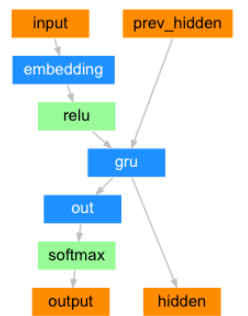

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()

        ### START CODE HERE ###

        self.hidden_size = hidden_size

        self.embedding =  nn.Embedding( output_size ,  hidden_size )
        self.gru = nn.GRU( hidden_size , hidden_size )
        self.out = nn.Linear( hidden_size , output_size ) #we want probabilities
        self.softmax = nn.LogSoftmax(dim=1)

        ### END CODE HERE ###

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)

        ### START CODE HERE ###

        output = F.relu(output) 
        output, hidden = self.gru(output,hidden)
        output = self.softmax(self.out(output[0]))

        ### END CODE HERE ###

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Adding Attention Module

In order to earn some training time, let's update our decode already, by adding an attention module. Recall that the attention module will compute attention weights on every encoder hidden state, and thus will compute a context vector summing up the relevant information at a given time. 

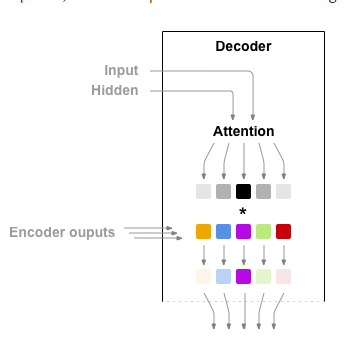

The decoder now contains: 

* a linear layer computing attention weights based on previous hidden state and previous output
* a dot-product operation computing a weighted sum (with computed attention weights) on encoder hidden states
* a linear layer called "attn_combine" applied to that context vector to produce the new input for recurrent module
* a recurrent module 
* as before, a linear layer followed by softmax to get ouptut probabilities

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training

For the training procedure, we'll add a teacher_forcing module, in order to guide the model during training. Both modules (encoder and decoder) will have their own optimizer, but there is only one global loss. 

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)  #initializing all encoder outputs to 0

    loss = 0

    for ei in range(input_length):   # parsing all input words and computing encoder outputs
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0] 

    decoder_input = torch.tensor([[SOS_token]], device=device) # initializing de oder first input as special token Start of Sentence

    decoder_hidden = encoder_hidden # passing the encoder last hidden state as the initial one for decoder

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length): #generating word by word
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di]) #comparing prediction to ground truth

            ### START CODE HERE ###

            #target_tensor is the ground truth
            decoder_input = target_tensor[di]  # Teacher forcing

            ### END CODE HERE ###

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1) #taking maximum probabilit output as candidate for prediction
            decoder_input = topi.squeeze().detach()  # detach from history as input, in order not to backprop on it

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token: # end of sentence
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

**Questions :**

* **Explain the line 26 : use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False**

Supplementary functions for measuring execution time

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Let's put the training procedure in a global function, handling number of epochs:

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate) # we could use Adam too
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss() # negative log likelihood minimization is equivalent to cross-entropy minimization for claissification

    for iter in tqdm(range(1, n_iters + 1)):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        ### START CODE HERE ###

        loss = train(input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion)
        
        ### END CODE HERE ###
        
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
            evaluateRandomly(encoder, decoder, n=1)

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

            showPlot(plot_losses)

Plot dependencies

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

We just need to define an evaluation function, and we're good !

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad(): # we do not want to keep gradients during inference, we do not train the model at this point
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()


        ### START CODE HERE ###

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        ### END CODE HERE ###

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000, plot_every=5000)

1m 41s (- 23m 41s) (5000 6%) 2.8218
> vous avez raison a ce sujet .
= you re right about that .
< you re such a the . . <EOS>

3m 20s (- 21m 44s) (10000 13%) 2.2517
> nous sommes en train de dejeuner .
= we re having dinner .
< we re out . <EOS>

5m 0s (- 20m 3s) (15000 20%) 1.9296
> vous imaginez des choses .
= you re imagining things .
< you re wasting . <EOS>

6m 41s (- 18m 23s) (20000 26%) 1.6931
> elle est appreciee de tout le monde .
= she is appreciated by everyone .
< she is absent by everyone . <EOS>

8m 21s (- 16m 42s) (25000 33%) 1.5261
> tu n es pas si vieux .
= you re not that old .
< you re not that old . <EOS>

10m 2s (- 15m 3s) (30000 40%) 1.3675
> je suis l un de vous .
= i m one of you .
< i m one of of . . <EOS>

11m 43s (- 13m 23s) (35000 46%) 1.2479
> je prends mon apres midi demain .
= i m taking tomorrow afternoon off .
< i m taking my tomorrow tomorrow . <EOS>

13m 24s (- 11m 44s) (40000 53%) 1.1397
> je travaille sur sa voiture .
= i m working on his car .
< i 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


20m 11s (- 5m 2s) (60000 80%) 0.7568
> elle est assez fachee .
= she is quite angry .
< she s always pretty . <EOS>

21m 53s (- 3m 22s) (65000 86%) 0.6955
> je vais bien maintenant .
= i m feeling fine now .
< i m well . <EOS>

23m 35s (- 1m 41s) (70000 93%) 0.6439
> tu es trop maigrichonne .
= you re too skinny .
< you re too skinny . <EOS>

25m 17s (- 0m 0s) (75000 100%) 0.5636
> il a un peu plus de quarante ans .
= he is a little over forty .
< he is getting years old . <EOS>


